https://dacon.io/competitions/official/235573/codeshare/693

Feature Engineering

1. Magnitude, row별 max, min, max-min, std, sum Feature 추가

2. 모든 magnitude들의 조합(2)으로 diff feature 추가 

3. 각 magnitude 별 max-max, min-min, sum-sum 을 구함

4. 정확히 이것이 무엇인지는 모르겠는데 ugriz를 다른 system으로 변환하는 것 같았습니다. (성능 차이 거의 없음)

5. fiberID별 fiberMag mean, (fiber_u,g,r,i,z)/fiberMag_mean

6. 아래 사이트를 읽어보고 icolor, scolor, p1 등 feature 추가
 -> https://www.sdss.org/dr16/algorithms/segue_target_selection/#Legacy

7. asinh 변환

8. 위에서 구한 diff feature들의 표준편차

9. 원본 Magnitude들 decomposition 수행하여 Feature 추가

10. Permutation Importance를 사용하여 Feature Selection


Modeling

1. LightGBM Single Model이었고 Parameter는 모두 Hyper Optimization으로 찾았습니다.

2. 'boosting_type': 'dart' 로 한것이 효과가 좋았습니다. 
 -> gbdt가 0.3285정도 나왔고 dart는 0.3255, goss는 0.3300 정도 나왔습니다.

3. stratifiedkfold 5fold를 사용했고 stratified에 type을 넣었습니다.

1. 라이브러리 및 데이터

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Library 예시
import pandas as pd # 데이터 분석
import numpy as np # 행렬 연산, version: 1.6.1

import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD, PCA, FastICA, FactorAnalysis, KernelPCA, DictionaryLearning
from sklearn.decomposition import IncrementalPCA, LatentDirichletAllocation,MiniBatchSparsePCA, SparsePCA

import itertools

train = pd.read_csv("C:/dataset/dacon_SDSS/train.csv")
test = pd.read_csv("C:/dataset/dacon_SDSS/test.csv")
submission = pd.read_csv("C:/dataset/dacon_SDSS/sample_submission.csv")

In [3]:
print("lightgbm",lgbm.__version__)
print('sklearn',sklearn.__version__)
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('python',sys.version)

lightgbm 2.3.1
sklearn 0.20.3
pandas 0.24.2
numpy 1.16.2
python 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


2. 데이터 전처리

In [3]:
# submission의 순서로 string으로 된 train type을 숫자로 변경
# https://dacon.io/competitions/official/235573/codeshare/690
column_number = {}
for i, column in enumerate(submission.columns[1:]):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))


In [12]:
# Feature Engineering하면서 계속 사용하게 될 각 Magnitude column(u,g,r,i,z)을 list로 변경
psfMag_col = [c for c in train.columns if c.find('psfMag') != -1]
fiberMag_col = [c for c in train.columns if c.find('fiberMag')!=-1]
petroMag_col = [c for c in train.columns if c.find('petroMag')!=-1]
modelMag_col = [c for c in train.columns if c.find('modelMag')!=-1]

'''
find()
존재 여부에 따라 해당하는 위치값을 반환하는 함수
찾는 값이 없는 경우 -1을 반환
'''


3. EDA

In [9]:
train.shape
test.shape

(199991, 24)

(10009, 22)

In [10]:
train['type_num'].nunique()

19

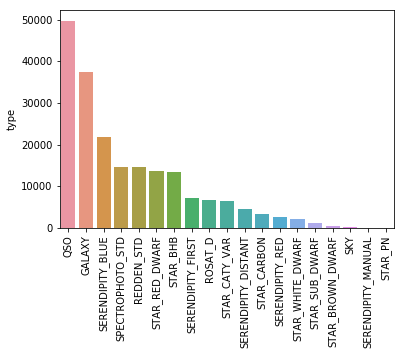

In [11]:
sns.barplot(train['type'].value_counts().index,train['type'].value_counts())
plt.xticks(rotation=90);

In [13]:
def plot_category_hist(data, col_list, category):
    for c in col_list:
        u = np.percentile(data[c],99.5)
        d = np.percentile(data[c],0.05)
        plt.figure(figsize=(12,5))
        for t in data[category].unique():
            sns.distplot(data.query(f'@d < @u and {category} == @t')[c])
        plt.title(c)
        plt.legend(data[category].unique())
        plt.show()

In [18]:
def plot_filter_each_target(data, unique_list, filter_list, xlabel):
    type_count = len(unique_list)
    row_count = int(type_count/5)+1
    f, a = plt.subplots(row_count, 5, figsize=(20, row_count*5))
    for i, t in enumerate(unique_list):
        row = int(i/5)
        col = int(i%5)
        ax = a[row][col]
        for c in filter_list:
            u = np.percentile(data[c],99.5)
            d = np.percentile(data[c],0.05)
            sns.distplot(data.query(f'@d < @u and type == @t')[c], ax=ax)
        ax.set_title(f'{xlabel}\n{t}')
        ax.legend(filter_list)
        ax.set_xticks((10,30))
        ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

In [17]:
plot_category_hist(train, psfMag_col, 'type')

TypeError: issubclass() arg 1 must be a class

In [19]:
u_feature = [c for c in train.columns if c.find('_u')!=-1]
plot_filter_each_target(train, train['type'].unique(), u_feature, 'u filter')

TypeError: issubclass() arg 1 must be a class

In [20]:
plot_filter_each_target(train, train['type'].unique(), psfMag_col, 'psf')

TypeError: issubclass() arg 1 must be a class

In [ ]:
train_eda = train.copy()

for c in psfMag_col:
    u = np.percentile(train_eda[c],99)
    d = np.percentile(train_eda[c],0.1)
    train_eda = train_eda.query(f"@d<@u")

diff_feature = []
for c1, c2 in itertools.combinations(psfMag_col[::-1],2):
    new_c = f'{c1}_{c2}_diff'
    train_eda[new_c] = train_eda[c1]-train_eda[c2]
    diff_feature.append(new_c)

"""
for i, (c1,c2) in enumerate(itertools.combinations(diff_feature,2)):
    plt.figure(figsize=(8,8))
    sns.scatterplot(c1,c2, data=train_eda, hue='type')
    plt.title(f'{c1} vs {c2}')
    plt.grid()
    plt.show()
    draw_count+=1 
"""

# 2 Mb 용량 제한 때문에 대표 하나만 그림
c1 = 'psfMag_z_psfMag_r_diff'
c2 = 'psfMag_r_psfMag_u_diff'
plt.figure(figsize=(8,8))
sns.scatterplot(c1,c2, data=train_eda, hue='type')
plt.title(f'{c1} vs {c2}')
plt.grid()
plt.show()

target 별로 같은 magnitude군이더라도 filter가 겹치지 않고 다른 분포를 이루는 것도 있다.

target 별로 filter들의 중심값이 다르다.

어떤 target은 filter 전체가 왼쪽으로(spectro photo) 치우쳐져 있는 것도 있다.

target 별 skew, kurtosis정도가 다 다르다.

target 별 max filter, min filter가 다르다

다른 magnitude 군이더라도 target 별 filter의 분포는 비슷하다.

diff feature 끼리 상호 작용하면 tree가 target을 나누기 좋을 것 같다.

outlier가 존재한다.

rare class가 존재한다.

Galaxy같은 일부 target은 다른 magnitude의 차이로 구별할 수 있을 것 같다.


4. 변수 선택 및 모델 구축

In [22]:
# zip 함수를 이용하여 각 Row별, Magnitude별 max, min, max-min, std, sum을 구한다.
# mean, skew, 등 다른 것들 시도 시 cv 점수가 안 좋아져서 사용하지 않음
for prefix, g in zip(['psfMag','fiberMag','petroMag','modelMag'], [psfMag_col, fiberMag_col, petroMag_col, modelMag_col]):
    train[f'{prefix}_max'] = train[g].max(axis=1)
    test[f'{prefix}_max'] = test[g].max(axis=1)
    
    train[f'{prefix}_min'] = train[g].min(axis=1)
    test[f'{prefix}_min'] = test[g].min(axis=1)
    
    train[f'{prefix}_diff'] = train[f'{prefix}_max'] - train[f'{prefix}_min']
    test[f'{prefix}_diff'] = test[f'{prefix}_max'] - test[f'{prefix}_min']
    
    train[f'{prefix}_std'] = train[g].std(axis=1)
    test[f'{prefix}_std'] = test[g].std(axis=1)
    
    train[f'{prefix}_sum'] = train[g].sum(axis=1)
    test[f'{prefix}_sum'] = test[g].sum(axis=1)

'''
zip()
동일한 개수로 이루어진 자료형을 묶어주는 역할을 하는 함수
list(zip([1, 2, 3], [4, 5, 6]))
>>> [(1, 4), (2, 5), (3, 6)]
'''

In [ ]:
# diff feature 추가 예: psfMag_z - psfMag_i 
# sdss lagacy solution 등을 보면 대 부분 mag간 차이를 사용하기 때문에 이런 diff feature가 의미가 있을 것이라고 판단
# 그리고 각 magnitude에서만 diff를 구하는 것이 아닌 itertools combinations를 활용하여 전체 magnitude에서 diff를 구함
# 총 190가지 조합이 나오고 여기서 안 좋은 것은 permutation importance를 활용하여 feature 제거 수행
diff_feature = []
for c1, c2 in itertools.combinations(psfMag_col[::-1]+fiberMag_col[::-1]+petroMag_col[::-1]+modelMag_col[::-1],2):
    new_c = f'{c1}_{c2}_diff'
    train[new_c] = train[c1]-train[c2]
    test[new_c] = test[c1]-test[c2]
    diff_feature.append(new_c)

In [ ]:
# 각 magnitude 별 max-max, min-min, sum-sum 을 구함
for c in itertools.combinations(['psfMag','fiberMag','petroMag','modelMag'],2):
    train[f'{c[0]}_{c[1]}_max_diff'] = train[f'{c[0]}_max'] - train[f'{c[1]}_max']
    test[f'{c[0]}_{c[1]}_max_diff'] = test[f'{c[0]}_max'] - test[f'{c[1]}_max']
    
    train[f'{c[0]}_{c[1]}_min_diff'] = train[f'{c[0]}_min'] - train[f'{c[1]}_min']
    test[f'{c[0]}_{c[1]}_min_diff'] = test[f'{c[0]}_min'] - test[f'{c[1]}_min']
    
    train[f'{c[0]}_{c[1]}_sum_diff'] = train[f'{c[0]}_sum'] - train[f'{c[1]}_sum']
    test[f'{c[0]}_{c[1]}_sum_diff'] = test[f'{c[0]}_sum'] - test[f'{c[1]}_sum']


In [ ]:
# 도메인 지식이 없어 정확히는 모르지만 아래와 같은 공식들이 있어 구현함
# 추가적으로 다른 것들도 시도하였는데 좋아지지 않음
# http://classic.sdss.org/dr4/algorithms/sdssUBVRITransform.html
def make_2flux_feature(train, test, c1,c2, func, mag_list=None):

    for c in mag_list:
        x=train[f'{c}_{c1}'].values
        y=train[f'{c}_{c2}'].values
        train[f'{c}_{func.__name__}'] = func(x,y)
        
        x=test[f'{c}_{c1}'].values
        y=test[f'{c}_{c2}'].values
        
        test[f'{c}_{func.__name__}'] = func(x,y)
        
def quasar_UB_jester(x1, x2):
    return 0.75*(x1-x2)-0.81

make_2flux_feature(train, test, 'u','g',quasar_UB_jester,['psfMag'])

def quasar_BV_jester(x1, x2):
    return 0.62*(x1-x2)+0.15

make_2flux_feature(train, test, 'g','r',quasar_BV_jester,['psfMag'])

def quasar_VR_jester(x1, x2):
    return 0.38*(x1-x2)+0.27

make_2flux_feature(train, test, 'r','i',quasar_VR_jester,['psfMag'])

def quasar_RcIc_jester(x1, x2):
    return 0.72*(x1-x2)+0.27

make_2flux_feature(train, test, 'u','g',quasar_RcIc_jester,['psfMag'])


In [ ]:
def groupby_helper(all_data, source, target, agg_func):
    temp = all_data.groupby(source)[target].agg(agg_func)
    new_col = ['_'.join(source)+'_' +c[0]+'_'+c[1] for c in itertools.product(target,agg_func)]
    temp.columns = new_col
    temp = temp.reset_index()
    all_data = all_data.merge(temp, on=source, how='left')
    return all_data, new_col

# fiberID별 fiber Magnitude 평균 aggregation 수행
all_data = pd.concat([train, test], ignore_index=True)
all_data, new_c = groupby_helper(all_data, ['fiberID'], fiberMag_col, ['mean'])

# 각 filter별 fiberMag/fiberMag_mean
for c1, c2 in zip(new_c, fiberMag_col):
    all_data[f'{c2}_div_mean'] = all_data[c2]/all_data[c1]


In [ ]:
# https://www.sdss.org/dr16/algorithms/segue_target_selection/#Legacy
all_data['psf_icolor'] = all_data['psfMag_u']*(-0.436) + all_data['psfMag_g']*(1.129) + all_data['psfMag_r']*(-0.119) + all_data['psfMag_i']*(-0.574) +0.1984
all_data['psf_scolor'] = all_data['psfMag_u']*(-0.249) + all_data['psfMag_g']*(0.794) + all_data['psfMag_r']*(-0.555) +0.234
all_data['psf_p1'] = (all_data['psfMag_u']-all_data['psfMag_g'])*(0.91) + (all_data['psfMag_g']-all_data['psfMag_r'])*(0.415) -1.280
all_data['psfMag_r_std_div'] = all_data['psfMag_r']/all_data['psfMag_r'].std()


In [ ]:
# https://www.sdss.org/dr16/algorithms/legacy_target_selection/
all_data['modelMag_orthogonal'] =(all_data['modelMag_r']-all_data['modelMag_i'])-(all_data['modelMag_g']-all_data['modelMag_r'])/4-0.177
all_data['modelMag_parallel'] = 0.7*(all_data['modelMag_g']-all_data['modelMag_r']) + 1.2*((all_data['modelMag_r']-all_data['modelMag_i'])-0.177)


In [ ]:
# https://www.sdss.org/dr12/algorithms/magnitudes/
color_list = ['u', 'g', 'r', 'i', 'z']
b_list = [1.4*10e-10, 0.9*10e-10, 1.2*10e-10, 1.8*10e-10, 7.4*10e-10]
f0_list = [24.63, 25.11, 24.80, 24.36, 22.83]
for c, b, f0 in zip(color_list, b_list, f0_list):
    all_data[f'psfMag_{c}_asinh'] = -2.5*np.log(10)*(np.arcsinh((all_data[f'psfMag_{c}']/f0)/(2*b))+np.log(b))


In [ ]:
# permutation importacne로 찾아낸 나쁜 feature들 제거
bad_feature = ['petroMag_i_modelMag_i_diff','petroMag_g_modelMag_g_diff','psfMag_g_modelMag_g_diff',
 'psfMag_g_petroMag_g_diff','psfMag_r_petroMag_r_diff','petroMag_modelMag_min_diff',
 'psfMag_fiberMag_min_diff','psfMag_modelMag_min_diff','psfMag_fiberMag_sum_diff',
 'psfMag_u_fiberMag_u_diff','psfMag_u_modelMag_u_diff','psfMag_modelMag_sum_diff',
 'psfMag_z_fiberMag_z_diff','psfMag_petroMag_min_diff','psfMag_z_modelMag_z_diff',
 'fiberMag_modelMag_sum_diff','psfMag_fiberMag_max_diff','psfMag_modelMag_max_diff',
 'petroMag_z_modelMag_z_diff','fiberMag_modelMag_min_diff','fiberMag_petroMag_min_diff',
 'fiberMag_modelMag_max_diff','petroMag_u_modelMag_u_diff','fiberMag_u_modelMag_u_diff',
 'fiberMag_z_petroMag_z_diff','petroMag_modelMag_sum_diff','fiberMag_z_modelMag_z_diff',
 'fiberMag_u_petroMag_u_diff','psfMag_z_petroMag_z_diff','petroMag_modelMag_max_diff',
 'psfMag_petroMag_max_diff','fiberMag_petroMag_max_diff','fiberMag_petroMag_sum_diff',
 'psfMag_u_petroMag_u_diff','petroMag_i_modelMag_z_diff','psfMag_petroMag_sum_diff',
 'fiberMag_u_div_mean','fiberMag_z_modelMag_i_diff','petroMag_z_petroMag_i_diff',
 'psfMag_z_petroMag_i_diff','psfMag_g_petroMag_r_diff','fiberMag_i_petroMag_z_diff',
 'fiberMag_z_petroMag_i_diff','petroMag_z','fiberMag_g_petroMag_u_diff',
 'psfMag_i_petroMag_z_diff','petroMag_z_modelMag_i_diff','fiberMag_r_petroMag_i_diff',
 'petroMag_sum','fiberMag_r_petroMag_g_diff','psfMag_r_petroMag_i_diff',
 'fiberMag_u','psfMag_u','petroMag_max',
 'petroMag_r_petroMag_g_diff','psfMag_i_petroMag_r_diff','petroMag_u',
 'fiberMag_r_modelMag_z_diff','petroMag_g_modelMag_r_diff','petroMag_diff',
 'petroMag_std','fiberMag_z_petroMag_r_diff','psfMag_i_fiberMag_g_diff',
 'psfMag_z_petroMag_r_diff','psfMag_g_petroMag_i_diff','fiberMag_r_modelMag_u_diff',
 'petroMag_r_modelMag_z_diff','fiberMag_g_petroMag_i_diff','fiberMag_z_modelMag_r_diff',
 'psfMag_i_psfMag_g_diff','psfMag_i_petroMag_g_diff','fiberMag_diff',
 'petroMag_z_petroMag_r_diff','psfMag_std','modelMag_std',
 'modelMag_diff','psfMag_diff','fiberMag_std',
 'petroMag_z_modelMag_r_diff','fiberMag_r_fiberMag_u_diff','psfMag_u_petroMag_r_diff',
 'fiberMag_u_petroMag_r_diff','psfMag_r_petroMag_z_diff','fiberMag_u_modelMag_r_diff',
 'petroMag_i_modelMag_g_diff','petroMag_r_petroMag_u_diff','fiberMag_z_fiberMag_g_diff',
 'psfMag_r_petroMag_u_diff','fiberMag_i_petroMag_g_diff','fiberMag_r_petroMag_u_diff',
 'psfMag_g_fiberMag_z_diff','petroMag_r_modelMag_u_diff','psfMag_g_modelMag_z_diff',
 'petroMag_i_petroMag_g_diff','psfMag_z_fiberMag_g_diff','petroMag_g_modelMag_i_diff',
 'fiberMag_z_modelMag_g_diff','modelMag_z_modelMag_g_diff','psfMag_z_psfMag_g_diff',
 'fiberMag_g_modelMag_z_diff','fiberMag_z_petroMag_g_diff','psfMag_z_petroMag_g_diff',
 'psfMag_g_petroMag_z_diff','petroMag_u_modelMag_r_diff','fiberMag_g_petroMag_z_diff',
 'psfMag_i_psfMag_u_diff','psfMag_u_petroMag_i_diff','psfMag_z_petroMag_u_diff',
 'petroMag_z_petroMag_g_diff','psfMag_i_fiberMag_u_diff','psfMag_u_fiberMag_i_diff',
 'psfMag_u_fiberMag_z_diff','petroMag_z_modelMag_g_diff','psfMag_i_modelMag_u_diff',
 'fiberMag_u_modelMag_z_diff','petroMag_g_modelMag_z_diff','fiberMag_u_petroMag_z_diff',
 'psfMag_i_petroMag_u_diff','fiberMag_i_fiberMag_u_diff','fiberMag_u_modelMag_i_diff',
 'petroMag_i_petroMag_u_diff','psfMag_u_modelMag_z_diff','petroMag_i_modelMag_u_diff',
 'psfMag_z_modelMag_u_diff','fiberMag_i_petroMag_u_diff','petroMag_z_petroMag_u_diff',
 'psfMag_z_fiberMag_u_diff','petroMag_z_modelMag_u_diff','fiberMag_z_modelMag_u_diff',
 'fiberMag_u_petroMag_i_diff','fiberMag_z_petroMag_u_diff','modelMag_z_modelMag_u_diff',
 'petroMag_u_modelMag_i_diff','fiberMag_z_fiberMag_u_diff','petroMag_u_modelMag_z_diff']


In [ ]:
train_columns = [c for c in all_data.columns if c not in ['id','type','type_num']+bad_feature]

# diff feature들 간의 표준편차(permutation importance로 걸러낸 것들 중에서..), 실험적으로 찾은 것
intersect_good_feature = list(set(diff_feature).intersection(set(train_columns)))
all_data['diff_feature_std'] = all_data[intersect_good_feature].std(axis=1)


In [ ]:
train = all_data.loc[all_data['type'].notnull()]
test = all_data.loc[all_data['type'].isnull()].reset_index(drop=True)


In [ ]:
def get_decomposition_feature(train, test, feature, param, decompose_func, prefix):
    n_components = param['n_components']
    de = decompose_func(**param)
    de_train = de.fit_transform(train[feature])
    de_test = de.transform(test[feature])
    train = pd.concat([train, pd.DataFrame(de_train,columns=[f'{prefix}_{c}' for c in range(n_components)])],axis=1)
    test = pd.concat([test, pd.DataFrame(de_test,columns=[f'{prefix}_{c}' for c in range(n_components)])],axis=1)
    return train, test

org_feature = psfMag_col+fiberMag_col+petroMag_col+modelMag_col
# decompostion해서 다시 feature로 추가, 원래 original feature만 사용하고 5개로 축소
decom_common_param = {'n_components':5,'random_state':42}
train, test = get_decomposition_feature(train, test, org_feature, decom_common_param, TruncatedSVD, 'tsvd5')
train, test = get_decomposition_feature(train, test, org_feature, decom_common_param, FastICA, 'ica5')


In [ ]:
# permutation importance를 사용하여 feature를 제거함
# https://eli5.readthedocs.io/en/latest/
# lb 0.001~0.003정도 좋아진 것으로 기억
print(len(train.columns))
train_columns = [c for c in train.columns if c not in ['id','type','type_num']+bad_feature]
num_class = train['type'].nunique()
print(len(train_columns))

5. 모델 학습 및 검증

In [ ]:
# hyper optimization으로 찾아낸 parameter
# lightgbm dart 사용, 보다 lb 0.03 정도 좋음
# gbdt가 0.3285라면 dart는 0.3255, goss는 0.3300
lgb_param_dart = {'objective': 'multiclass', 
 'num_class': 19, 
 'boosting_type': 'dart', 
 'subsample_freq': 5, 
 'num_leaves': 92, 
 'min_data_in_leaf': 64, 
 'subsample_for_bin': 23000, 
 'max_depth': 10, 
 'feature_fraction': 0.302, 
 'bagging_fraction': 0.904, 
 'lambda_l1': 0.099, 
 'lambda_l2': 1.497, 
 'min_child_weight': 38.011, 
 'nthread': 32, 
 'metric': 'multi_logloss', 
 'learning_rate': 0.021, 
 'min_sum_hessian_in_leaf': 3, 
 'drop_rate': 0.846244, 
 'skip_drop': 0.792465, 
 'max_drop': 65,
 'seed': 42,
 'n_estimators': 1000}

In [ ]:
print(train_columns)
print(lgb_param_dart)
x_train = train.copy()
y_train = train['type_num']
x_test = test.copy()

num_class = lgb_param_dart['num_class']
oof_train = np.zeros((len(x_train),num_class))
oof_test = np.zeros((len(x_test),num_class))
log_loss_score_list= []   
NFOLD = 5
SEED = 42

# stratifiedkfold 5 fold 사용
folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=42)
for fold_, (trn_index, val_index) in enumerate(folds.split(x_train, y_train)):
    print(f"{fold_+1} FOLD Start!!")
    trn_x, trn_y = x_train.iloc[trn_index][train_columns], y_train.iloc[trn_index]
    val_x, val_y = x_train.iloc[val_index][train_columns], y_train.iloc[val_index]
    dtrain = lgbm.Dataset(trn_x, label=trn_y, silent=True)
    dcross = lgbm.Dataset(val_x, label=val_y, silent=True)
    
    # dart는 얼리스탑핑이 안되서 한번 num_boost_round를 넉넉히 돌린다음에 5fold에서 가장 좋았던 round로 고정하고 돌린다.
    clf = lgbm.train(lgb_param_dart, train_set=dtrain, num_boost_round=1000, valid_sets=[dtrain, dcross], 
                       verbose_eval=100)
    
    val_pred = clf.predict(val_x)
    oof_train[val_index, :] = val_pred
    
    log_loss_score = log_loss(val_y, val_pred)
    log_loss_score_list.append(log_loss_score)
    print(f"{fold_+1} FOLD LogLoss: ", log_loss_score)
    
    # 5fold 평균으로 제출
    oof_test += clf.predict(x_test[train_columns])/NFOLD


6. 결과 및 결언

In [ ]:
print(log_loss_score_list)
np.mean(log_loss_score_list), np.std(log_loss_score_list)


In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
submission = pd.DataFrame(data=oof_test, columns=sample_submission.columns[1:], index=sample_submission['id'])
submission.to_csv('../output/submission.csv', index=True)